In [18]:
!date

Wed Jul 21 20:28:07 PDT 2021


# Class DE isoform hidden by gene

In [19]:
import anndata
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.patches as mpatches
import matplotlib.colors as mcolors
import scanpy as sc
from scipy.stats import ks_2samp, ttest_ind
import ast
from scipy.sparse import csr_matrix
import warnings
warnings.filterwarnings('ignore')


import sys
sys.path.append('../../../BYVSTZP_2020/dexpress')
from dexpress import dexpress, utils, plot

#sys.path.append('../../../BYVSTZP_2020/trackfig')
#from trackfig.utils import get_notebook_name
#from trackfig.trackfig import trackfig 

#TRACKFIG = "../../../BYVSTZP_2020/trackfig.txt"
#NB = get_notebook_name()

fsize=20

plt.rcParams.update({'font.size': fsize})
%config InlineBackend.figure_format = 'retina'

In [20]:
subclass_cmap = pd.read_csv('../metadata_files/CTX_Hip_anno_SSv4.csv', index_col='subclass_label',usecols=['subclass_label','subclass_color'])
subclass_cmap = subclass_cmap.drop_duplicates()
subclass_cmap = subclass_cmap.subclass_color.apply(lambda x: mcolors.to_rgb(x) )
subclass_cmap = subclass_cmap.to_dict()

In [21]:
cluster_cmap = {
"Astro": (0.38823529411764707, 0.4745098039215686,  0.2235294117647059 ),  # 637939,
"Endo" : (0.5490196078431373,  0.6352941176470588,  0.3215686274509804 ),  # 8ca252,
"SMC"  : (0.7098039215686275,  0.8117647058823529,  0.4196078431372549 ),  # b5cf6b,
"VLMC" : (0.807843137254902,   0.8588235294117647,  0.611764705882353  ),  # cedb9c,
"Low Quality" : (0,0,0),
"L2/3 IT" : (0.9921568627450981,  0.6823529411764706,  0.4196078431372549  ),  # fdae6b
"L5 PT" : (0.9921568627450981,  0.8156862745098039,  0.6352941176470588  ),  # fdd0a2
"L5 IT" : (0.5176470588235295,  0.23529411764705882, 0.2235294117647059 ),  # 843c39
"L5/6 NP": "#D43F3A",
"L6 CT" : (0.8392156862745098,  0.3803921568627451,  0.4196078431372549 ),  # d6616b
"L6 IT" : (0.9058823529411765,  0.5882352941176471,  0.611764705882353  ),  # e7969c
"L6b" : (1.0,                 0.4980392156862745,  0.054901960784313725),  # ff7f0e
"L6 IT Car3" : (1.0,                 0.7333333333333333,  0.47058823529411764 ),  # ffbb78
"Lamp5" : (0.19215686274509805, 0.5098039215686274,  0.7411764705882353  ),  # 3182bd # blues
"Sncg" : (0.4196078431372549,  0.6823529411764706,  0.8392156862745098  ),  # 6baed6
"Vip" : (0.6196078431372549,  0.792156862745098,   0.8823529411764706  ),  # 9ecae1
"Sst" : (0.7764705882352941,  0.8588235294117647,  0.9372549019607843  ),  # c6dbef
"Pvalb":(0.7372549019607844,  0.7411764705882353,  0.8627450980392157  ),  # bcbddc
}

In [22]:
gene = anndata.read_h5ad("../../data/notebook/revision/gene.h5ad")
struct_dict = {
    "ACA": "CTX",
    "AI": "CTX",
    "ALM": "CTX",
    "AUD": "CTX",
    "ENT": "HPF",
    "ENTl": "HPF",
    "ENTm": "HPF",
    "GU-VISC-AIp": "CTX",
    "HIP": "HPF",
    "MOp": "CTX",
    "MOs-FRP": "CTX",
    "ORB": "CTX",
    "PAR-POST-PRE": "HPF",
    "PAR-POST-PRE-SUB-ProS": "HPF",
    "PL-ILA": "CTX",
    "PL-ILA-ORB": "CTX",
    "PTLp": "CTX", 
    "RSP": "CTX",
    "RSPv": "CTX",
    "SSp": "CTX",
    "SSs": "CTX",
    "SSs-GU-VISC-AIp": "CTX",
    "SUB-ProS": "HPF",
    "TEa_PERI-ECT": "CTX",
    "VIS": "CTX",
    "VISpl-VISpor": "CTX",
    "VISl-VISal-VISli": "CTX",
    "VISam-VISpm": "CTX",
    "VISl": "CTX",
    "VISm": "CTX",
    "VISp": "CTX",
}
gene.obs['struct_label']=gene.obs["region_label"].map(struct_dict)
gene.obs.struct_label.value_counts()

HPF    6464
CTX    1379
Name: struct_label, dtype: int64

In [23]:
isoform = anndata.read_h5ad("../../data/notebook/revision/isoform.h5ad")
isoform.obs['struct_label']=isoform.obs["region_label"].map(struct_dict)

In [24]:
isoform = isoform[:,isoform.var.sort_values("gene_id").index]
gene = gene[:,gene.var.sort_values("gene_id").index]

In [25]:
isoform = isoform[isoform.obs.eval("subclass_label != 'L5 IT'").values]
gene = gene[gene.obs.eval("subclass_label != 'L5 IT'").values]

In [26]:
print(isoform.shape)
print(gene.shape)

(7843, 66698)
(7843, 21420)


In [27]:
mask = np.logical_or(gene.obs.class_label == "GABAergic", gene.obs.class_label == "GABAergic")
m_gene = gene[mask]
m_gene.obs.subclass_label.value_counts()

Sst          494
Vip          388
Pvalb        276
Lamp5        241
Sncg         198
Meis2         61
Sst Chodl     12
Name: subclass_label, dtype: int64

In [28]:
structs = gene.obs.struct_label.unique()
subclasses = gene.obs.subclass_label.unique()
breakdown = pd.DataFrame(index=subclasses, columns=structs)
for struct in structs:
    m = gene.obs.struct_label == struct
    r = gene.obs[m]
    d = r.subclass_label.value_counts()
    d = d.to_dict()
    breakdown[struct] = breakdown.index.map(d)
c = 2 #minimum number of columns that must satisfy criteria
n = 50 #minimum number of cells
b = breakdown.applymap(lambda x: x >=n)
for struct in structs:
    b[struct] = b[struct].map({True:1,False:0})
m2 = b.sum(axis=1) >= c
f_breakdown =breakdown[m2]
f_breakdown

,HPF,CTX
Vip,277,111
Sst,419,75
Lamp5,185,56


In [29]:
def gene_dexpress(c_gene):
    mat           = c_gene.layers["log1p"].todense()
    components    = c_gene.obs.cell_id.values
    features      = c_gene.var.gene_name.values
    assignments   = c_gene.obs.struct_label.values

    unique = np.unique(assignments)
    nan_cutoff = 0.9 # of elements in cluster
    corr_method = "bonferroni"


    p_raw, stat, es, nfeat = dexpress.dexpress(mat, components, features, assignments, nan_cutoff=nan_cutoff)
    p_raw = p_raw/2
    p_corr = utils.correct_pval(p_raw, nfeat, corr_method)

    s = stat

    markers_gene = dexpress.make_table(assignments, features, p_raw, p_corr, es)

    # convert the 0 pvalues to the smallest possible float
    markers_gene["p_corr"][markers_gene.eval("p_corr == 0").values] = sys.float_info.min
    markers_gene = markers_gene.query("es > 0")
    return markers_gene

In [30]:
def isoform_dexpress(c_isoform):
    mat         = c_isoform.layers["log1p"].todense() # expects dense matrix
    components  = c_isoform.obs.cell_id.values
    features    = c_isoform.var.transcript_name.values
    assignments = c_isoform.obs.struct_label.values

    unique = np.unique(assignments)
    nan_cutoff = 0.9 # of elements in cluster
    corr_method = "bonferroni"


    p_raw, stat, es, nfeat = dexpress.dexpress(mat, components, features, assignments, nan_cutoff=nan_cutoff)
    p_raw = p_raw/2
    p_corr = dexpress.correct_pval(p_raw, nfeat, corr_method)

    s = stat

    markers_isoform = dexpress.make_table(assignments, features, p_raw, p_corr, es)

    # convert the 0 pvalues to the smallest possible float
    markers_isoform["p_corr"][markers_isoform.eval("p_corr == 0").values] = sys.float_info.min
    markers_isoform = markers_isoform.query("es > 0")
    return markers_isoform

In [31]:
f_breakdown.index

CategoricalIndex(['Vip', 'Sst', 'Lamp5'], categories=['CA1-ProS', 'DG', 'CA3', 'IG-FC', 'L2/3 IT RHP', 'NP SUB', 'SUB-ProS', 'L6 CT CTX', ...], ordered=False, dtype='category')

In [32]:
markers_gene = pd.DataFrame(columns=['index','name','p_raw','p_corr','es','index_name','subclass'])
markers_isoform = pd.DataFrame(columns=['index','name','p_raw','p_corr','es','index_name','subclass'])
for subclass in f_breakdown.index:
    #only want gabaergic
    mask = np.logical_and(gene.obs.subclass_label==subclass ,np.logical_or(gene.obs.class_label == "GABAergic", gene.obs.class_label == "GABAergic"))

    c_gene = gene[mask]
    c_isoform = isoform[mask]
    temp_gene = gene_dexpress(c_gene)
    temp_gene['subclass'] = subclass
    markers_gene = pd.concat([markers_gene,temp_gene])
    temp_isoform = isoform_dexpress(c_isoform)
    temp_isoform['subclass'] = subclass
    markers_isoform = pd.concat([markers_isoform,temp_isoform])
    

21-Jul-21 20:28:57 - 1 of 2 assignments: CTX
21-Jul-21 20:28:57 - 2 of 2 assignments: HPF
21-Jul-21 20:28:58 - 1 of 2 assignments: CTX
21-Jul-21 20:28:59 - 2 of 2 assignments: HPF
21-Jul-21 20:29:00 - 1 of 2 assignments: CTX
21-Jul-21 20:29:00 - 2 of 2 assignments: HPF
21-Jul-21 20:29:00 - 1 of 2 assignments: CTX
21-Jul-21 20:29:01 - 2 of 2 assignments: HPF
21-Jul-21 20:29:01 - 1 of 2 assignments: CTX
21-Jul-21 20:29:01 - 2 of 2 assignments: HPF
21-Jul-21 20:29:02 - 1 of 2 assignments: CTX
21-Jul-21 20:29:02 - 2 of 2 assignments: HPF


In [33]:
#mask = np.logical_and(gene.obs.subclass_label == 'Vip', np.logical_or(gene.obs.class_label == "Glutamatergic", gene.obs.class_label == "GABAergic"))
#mask = (gene.obs.subclass_label == 'Vip')

#c_gene = gene[mask]
#c_isoform = isoform[mask]
#markers_gene= gene_dexpress(c_gene)
#markers_isoform = isoform_dexpress(c_isoform)

# Want to make a mask to return the isoforms for which the isoform is differential but the gene is not

In [34]:
alpha =0.01/len(f_breakdown.index) #second bonferroni correction for multiple subclasses being tested
fc = 2

relevant_genes = markers_gene.p_corr < alpha

markers_gene["index_name"] = markers_gene["index"] + "_" + markers_gene.name.apply(lambda x: "".join(x.split("_")[:-1]))
markers_isoform["index_name"] = markers_isoform["index"] + "_" + markers_isoform.name.apply(lambda x: "-".join(x.split("-")[:-1]))

setdiff = np.setdiff1d(markers_isoform["index_name"].values, markers_gene[relevant_genes]["index_name"].values)

In [35]:
markers_isoform = markers_isoform[markers_isoform["index_name"].isin(setdiff)].sort_values(["es", "p_corr"])

markers_isoform = markers_isoform.query(f"p_corr < {alpha}")
markers_isoform.sort_values("es")[::-1][:20]

,index,name,p_raw,p_corr,es,index_name,subclass
111797,HPF,Pnoc-202_ENSMUST00000224594.2,5.40474e-07,0.00121607,1.53054,HPF_Pnoc,Lamp5
111798,HPF,Pnoc-201_ENSMUST00000059339.6,1.243e-06,0.00279676,1.46664,HPF_Pnoc,Lamp5
68938,HPF,Calb2-201_ENSMUST00000003754.8,2.23698e-06,0.00325928,1.35226,HPF_Calb2,Vip
97722,HPF,Arcn1-205_ENSMUST00000217194.2,5.48376e-07,0.00123385,1.27036,HPF_Arcn1,Lamp5
960,CTX,Chordc1-208_ENSMUST00000217031.2,3.54845e-11,6.56819e-08,1.2202,CTX_Chordc1,Vip
44980,CTX,Hnrnph2-202_ENSMUST00000059297.6,1.2432e-06,0.00230116,1.15194,CTX_Hnrnph2,Vip
118344,HPF,Unc5c-202_ENSMUST00000106236.9,2.95735e-08,6.65404e-05,1.14378,HPF_Unc5c,Lamp5
10152,CTX,Rtn1-205_ENSMUST00000150156.2,8.39311e-08,0.000281505,1.10697,CTX_Rtn1,Sst
42191,CTX,Ttc1-201_ENSMUST00000048578.3,1.89572e-08,5.13929e-05,1.07195,CTX_Ttc1,Lamp5
76544,HPF,Nmt1-202_ENSMUST00000135332.2,1.99553e-09,2.90749e-06,1.03956,HPF_Nmt1,Vip


In [47]:
markers_gene[markers_gene.name.str.contains("Chordc1")]
#markers_gene[markers_gene.name.str.contains("Kifap")]

,index,name,p_raw,p_corr,es,index_name,subclass
220,CTX,Chordc1_ENSMUSG00000001774.9,0.0340069,1,0.210639,CTX_Chordc1,Vip
220,CTX,Chordc1_ENSMUSG00000001774.9,0.485633,1,0.00251443,CTX_Chordc1,Sst
21640,HPF,Chordc1_ENSMUSG00000001774.9,0.445628,1,0.0188191,HPF_Chordc1,Lamp5


In [48]:
#specific_cluster = "Glutamatergic"
#specific_gene = "Kifap3_ENSMUSG00000026585.14"
#specific_isoform = "Kifap3-202_ENSMUST00000077642.12"

#specific_cluster = "ENTl"
specific_cluster = "HPF"
specific_gene = "Chordc1_ENSMUSG00000001774.9"
specific_isoform = "Chordc1-208_ENSMUST00000217031.2"
specific_subclass = 'Vip'

In [49]:
def violinplot(data, ax, **kwd): 
    xticklabels = kwd.get("xticklabels", [])
    xticks = kwd.get("xticks", [])
    selected = kwd.get("selected", None)
    color = kwd.get("color", "grey")
    
    if  len(xticks)==0: xticks = np.arange(len(data))+1;
    if  len(xticklabels)==0: xticklabels = np.arange(len(data))+1;
    assert(len(xticks) == len(xticklabels))
        
    violins = ax.violinplot(data, positions=xticks, showmeans=False, showmedians=False, showextrema=False)
    
    for vidx, v in enumerate(violins['bodies']):
        v.set_facecolor(color)
        v.set_edgecolor('black')
        v.set_alpha(1)
        if selected == vidx:
            v.set_facecolor("#D43F3A")

            
    
    for didx, d in enumerate(data):
        x = xticks[didx]
        xx = np.random.normal(x, 0.04, size=len(d))
        
        # actual points
        ax.scatter(xx, d, s = 5, color="white", edgecolor="black", linewidth=1)
        
        # mean and error bars
        mean = np.mean(d)
        stdev = np.sqrt(np.var(d))
        ax.scatter(x, mean, color="lightgrey", edgecolor="black", linewidth=1, zorder=10)    
        ax.vlines(x, mean - stdev, mean+stdev, color='lightgrey', linestyle='-', lw=2, zorder=9)
        
    ax.set(**{"xticks": xticks, "xticklabels":xticklabels})
    
    return ax


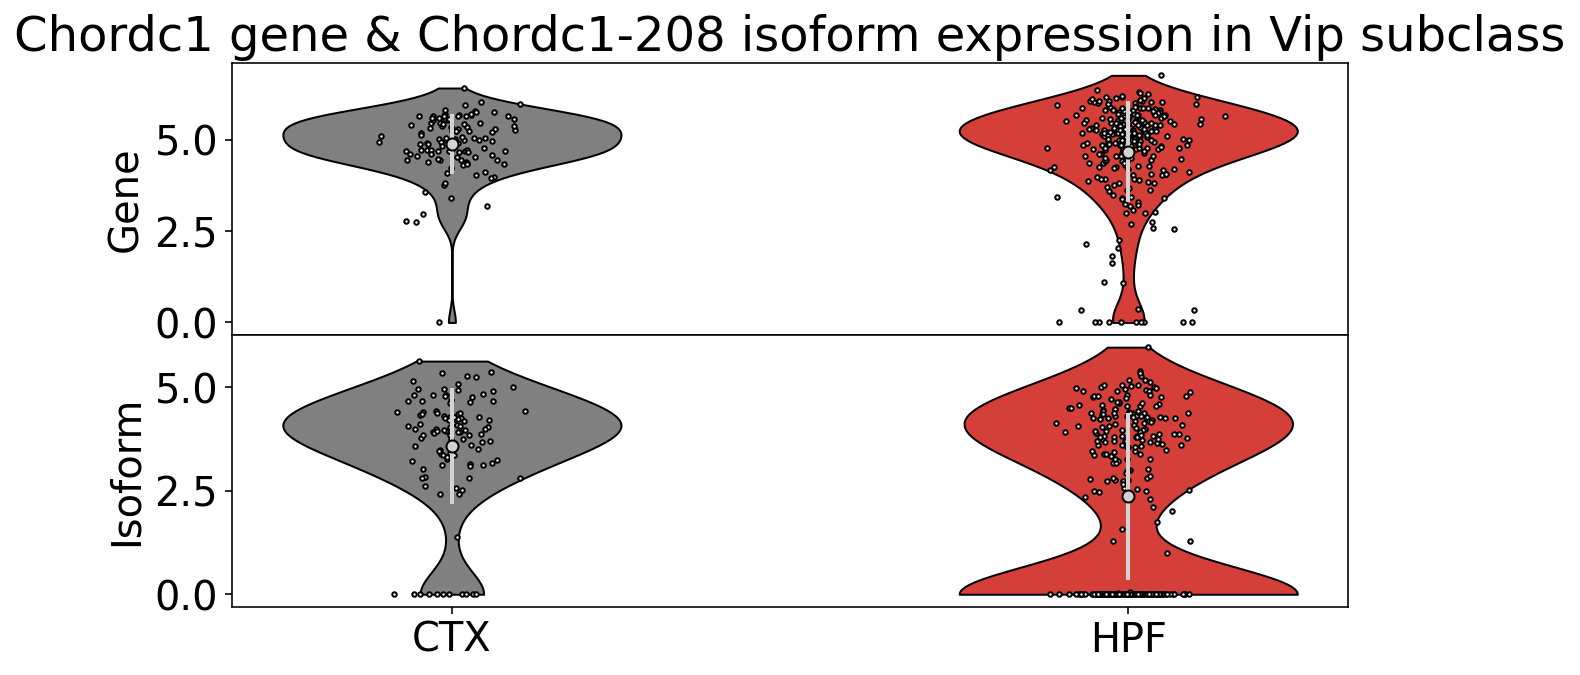

In [50]:
fig, ax = plt.subplots(figsize=(10,5), nrows=2, sharex=True)
fig.subplots_adjust(hspace=0, wspace=0)

mask = np.logical_and(gene.obs.subclass_label == specific_subclass, np.logical_or(gene.obs.class_label == "Glutamatergic", gene.obs.class_label == "GABAergic"))
c_gene = gene[mask]
c_isoform = isoform[mask]
# Declare
unique = np.unique(c_gene.obs.struct_label)
unique = np.delete(unique, np.where(unique=="Low Quality"))
unique = np.delete(unique, np.where(unique=="Non-Neuronal"))
labels = unique
lidx = np.arange(1, len(labels)+1)  # the label locations
midx = np.where(unique==specific_cluster)[0][0]

## Plot
# Gene
x = []
for c in unique:
    x.append(np.asarray(c_gene[c_gene.obs.struct_label==c][:,c_gene.var.gene_name==specific_gene].layers["log1p"].todense()).reshape(-1).tolist())

violinplot(x, ax[0], selected=midx)

# Isoform
x = []
for c in unique:
    x.append(np.asarray(c_isoform[c_isoform.obs.struct_label==c][:,c_isoform.var.transcript_name==specific_isoform].layers["log1p"].todense()).reshape(-1).tolist())

violinplot(x, ax[1], selected=midx, xticks=lidx, xticklabels=labels)
## Style
ax[0].set(**{
    "title":"{} gene & {} isoform expression in {} subclass".format(specific_gene.split("_")[0], specific_isoform.split("_")[0],specific_subclass),
    "ylabel":"Gene",
})

#need to figure out what ax[0] and ax[1] are
ymin, ymax = ax[1].get_ylim()
ax[1].set(**{
    "ylabel":"Isoform",
    "ylim": (ymin, ymax),
})

plt.savefig("../../figures/struct_subclass_DE_violin_all.png", bbox_inches='tight',dpi=300)
plt.show()

# gene.obs

In [51]:
#c = np.asarray(isoform[:, isoform.var.transcript_name==specific_isoform].layers["log1p"].todense()).reshape(-1)
isoform[:, isoform.var.transcript_name==specific_isoform]

View of AnnData object with n_obs × n_vars = 7843 × 1
    obs: 'cell_id', 'cluster_id', 'cluster_label', 'subclass_id', 'subclass_label', 'region_label', 'class_label', 'cluster_color', 'class_id', 'cell_counts', 'leiden', 'louvain', 'struct_label'
    var: 'transcript_id', 'gene_id', 'gene_name', 'transcript_name', 'length', 'gene_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'hvg', 'leiden', 'louvain', 'neighbors'
    obsm: 'X_nca', 'X_nca_tsne', 'X_pca', 'X_pca_tsne'
    layers: 'log1p', 'norm', 'raw', 'scaled'
    obsp: 'connectivities', 'distances'

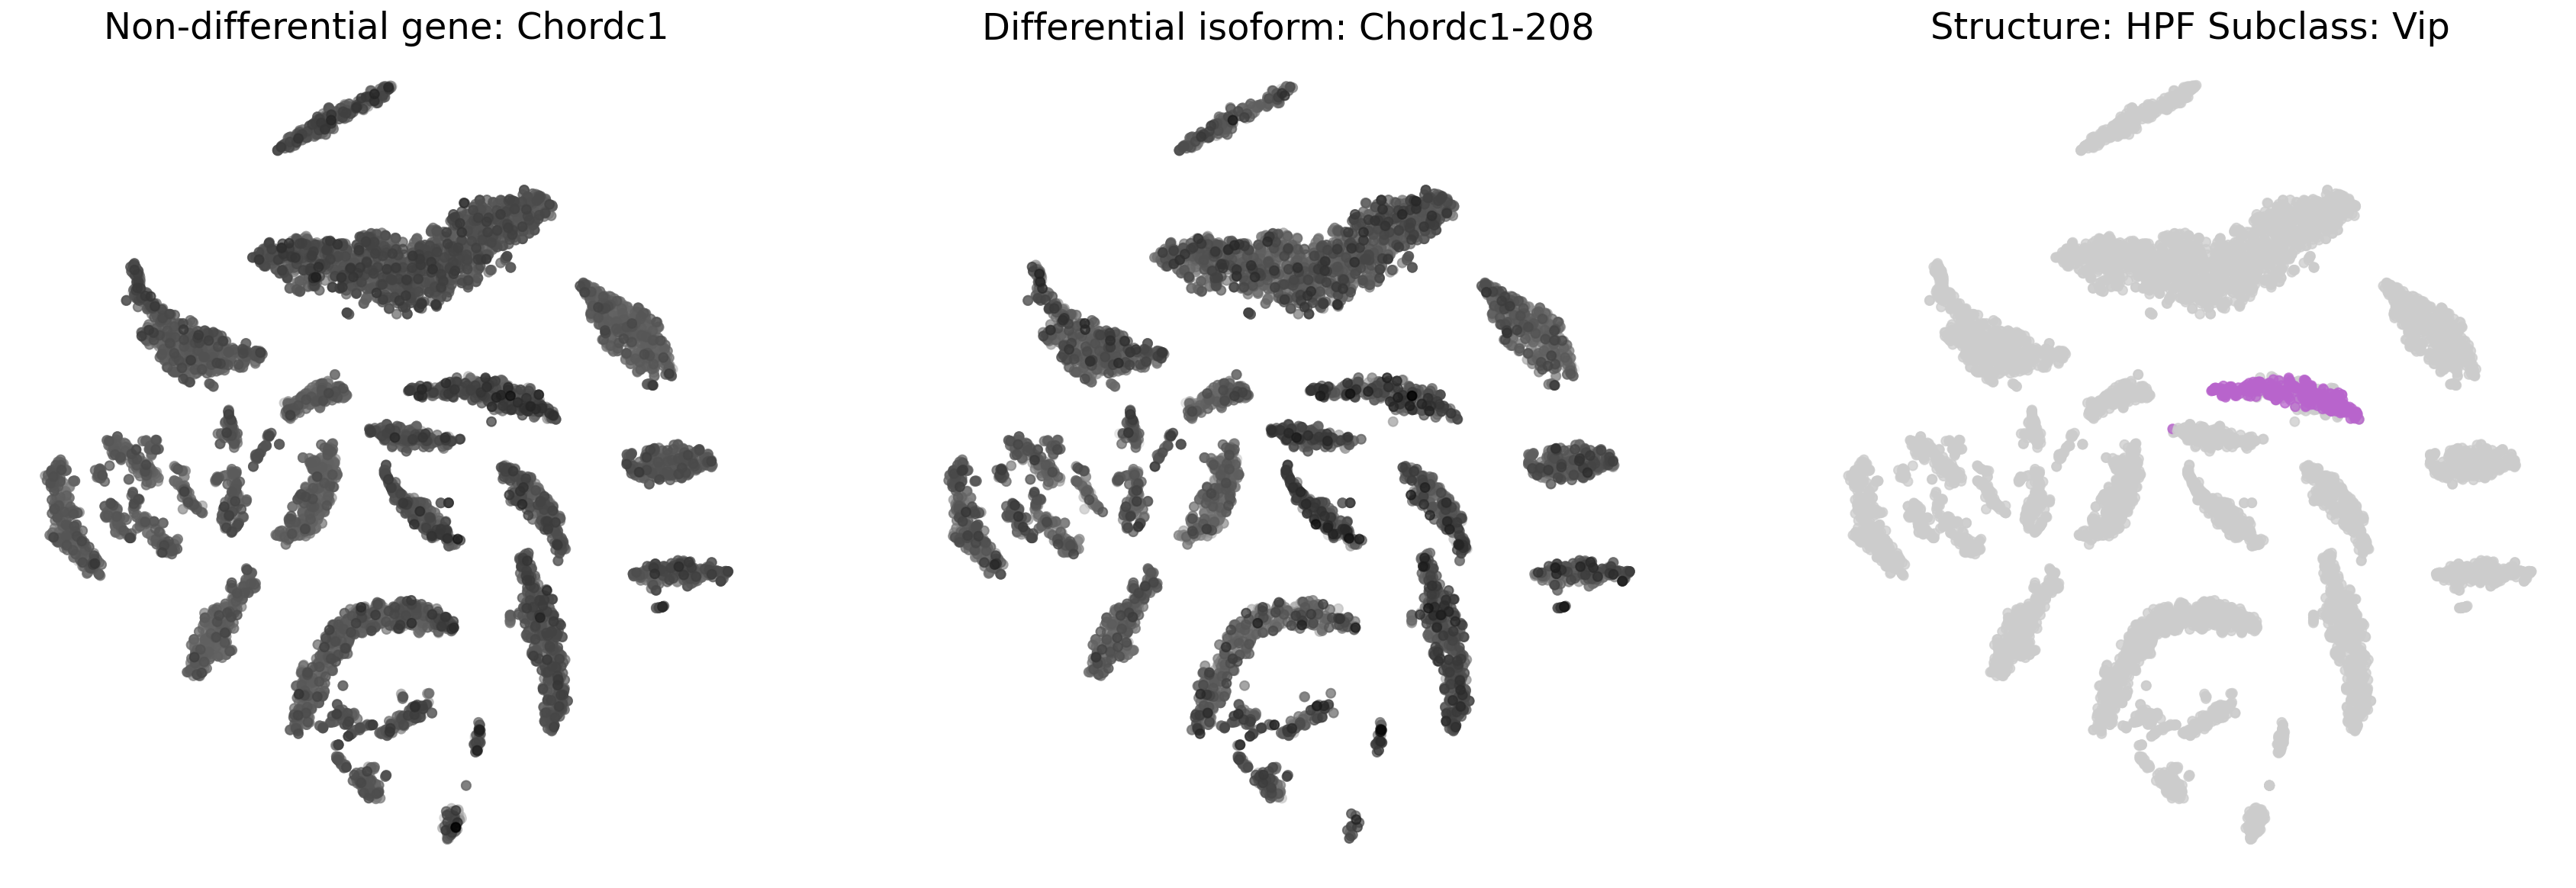

In [62]:
#this figure doesnt really make sense to use
complement_color = (0.8, 0.8, 0.8, 1.0)

fig, ax = plt.subplots(figsize=(30,10), ncols=3)

x = gene.obsm["X_nca_tsne"][:,0]
y = gene.obsm["X_nca_tsne"][:,1]
c = np.asarray(gene[:, gene.var.gene_name==specific_gene].layers["log1p"].todense()).reshape(-1)
argsort = np.argsort(c)
x = x[argsort]
y = y[argsort]
c = c[argsort]
cmap="Greys"
alpha = 0.75
ax[0].set_title("Non-differential gene: {}".format(specific_gene.split("_")[0]))

ax[0].scatter(x, y, c=c, cmap=cmap, alpha=alpha)
ax[0].set_axis_off()


x = gene.obsm["X_nca_tsne"][:,0]
y = gene.obsm["X_nca_tsne"][:,1]
c = np.asarray(isoform[:, isoform.var.transcript_name==specific_isoform].layers["log1p"].todense()).reshape(-1)
argsort = np.argsort(c)
x = x[argsort]
y = y[argsort]
c = c[argsort]
cmap="Greys"
alpha = 0.75
ax[1].set_title("Differential isoform: {}".format(specific_isoform.split("_")[0]))

ax[1].scatter(x, y, c=c, cmap=cmap, alpha=alpha)
ax[1].set_axis_off()

x = gene.obsm["X_nca_tsne"][:,0]
y = gene.obsm["X_nca_tsne"][:,1]
c = gene.obs["subclass_label"]==specific_cluster
c = gene.obs["subclass_label"].astype(str).map(subclass_cmap).tolist()
indices = np.where(np.logical_or(gene.obs["struct_label"]!=specific_cluster, gene.obs["subclass_label"]!=specific_subclass))[0]
replacements=[complement_color]*len(indices)
for (index, replacement) in zip(indices, replacements):
    c[index] = replacement
alpha=0.75
cmap="nipy_spectral_r"

ax[2].scatter(x, y, c=c, cmap=cmap, alpha=alpha)
ax[2].set_axis_off()
ax[2].set_title("Structure: {} Subclass: {}".format(specific_cluster, specific_subclass))
plt.savefig("../../figures/class_DE_nca_all.png", bbox_inches='tight',dpi=300)
plt.show()

In [58]:
identified_isoforms = markers_isoform["name"].explode().astype(str)

In [59]:
identified_genes = identified_isoforms.apply(lambda x: x.split("-")[0:-1][0])

In [60]:
print("{} isoforms from {} genes identified.".format(identified_isoforms.shape[0], identified_genes.nunique()))

93 isoforms from 77 genes identified.


In [61]:
markers_isoform.to_csv("../../tables/unordered/struct_subclass_DE.csv")